# Baseline Model: XGBoost
In this notebook, we forecast the fastest Bitcoin transaction fee (sats/vByte) using XGBoost Regressor. 

### Why We Chose XGBoost as a Baseline Model
We selected XGBoost as one of our baseline models because it provides a strong balance between performance, interpretability, and efficiency when working with structured tabular data. Unlike traditional linear models, XGBoost can effectively capture non-linear relationships and complex interactions between features, which includes both temporal patterns (via lag features) and contextual signals (like mempool and market conditions). 

Our target variable recommended_fee_fastestFee is not only time-dependent but also correlates with other recommended fee rates (e.g., halfHourFee, hourFee, etc.), which serve as important external features. When there are known correlations between the target and input features in the presence of redundancy or nonlinearity, XGBoost offers both high performance and interpretability. The exploratory data analysis confirms these relationships and reveals substantial variability and temporal structure in the data, which makes simpler linear models less effective. XGBoost, in contrast, is robust to multicollinearity, handles missing data gracefully, and naturally incorporates lag features. Additionally, it provides useful feature importance insights and performs well with minimal preprocessing, which makes it a practical and reliable starting point for benchmarking more complex forecasting models.

By tuning key hyperparameters and evaluating the model with MAE and RMSE, we can gauge how well tree-based methods handle fee rate prediction and set a meaningful performance benchmark.


### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import joblib  
from scipy.stats import uniform, randint
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import seaborn as sns
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split, ForecastingRandomizedSearchCV
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_error as mean_absolute_error_sktime
from sktime.split import SlidingWindowSplitter

In [2]:
import sys
sys.path.append("../scripts")
from XGBoost import data_split, build_random_search

### Load data
Due to limit of computational resourses, we select one-week data as our dataset. To ensure that we only train on complete data, we drop the lag rows which contain NaN values introduced by lag feature creation. 

In [3]:
df = pd.read_parquet('../data/processed/preprocessed_xgboost_15min.parquet')
df.dropna(inplace = True)
df.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,recommended_fee_fastestFee_lag_183,recommended_fee_fastestFee_lag_184,recommended_fee_fastestFee_lag_185,recommended_fee_fastestFee_lag_186,recommended_fee_fastestFee_lag_187,recommended_fee_fastestFee_lag_188,recommended_fee_fastestFee_lag_189,recommended_fee_fastestFee_lag_190,recommended_fee_fastestFee_lag_191,recommended_fee_fastestFee_lag_192
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-07 02:00:00,1.567569e+06,997970.250000,3438.666667,4.606073e+06,3.287990,4.000000,3.333333,3.000000,2.0,1.0,...,2.000000,3.000000,2.0,5.0,4.333333,3.333333,2.333333,2.000000,3.000000,2.000000
2025-03-07 02:15:00,1.548980e+06,997953.083333,3082.333333,3.224778e+06,2.663831,3.000000,2.666667,2.666667,2.0,1.0,...,3.000000,2.000000,3.0,2.0,5.000000,4.333333,3.333333,2.333333,2.000000,3.000000
2025-03-07 02:30:00,1.455481e+06,997935.666667,1893.000000,2.763749e+06,2.318819,2.666667,2.666667,2.666667,2.0,1.0,...,3.000000,3.000000,2.0,3.0,2.000000,5.000000,4.333333,3.333333,2.333333,2.000000
2025-03-07 02:45:00,1.346890e+06,997940.666667,1620.666667,2.692494e+06,1.975272,2.333333,2.333333,2.333333,2.0,1.0,...,2.333333,3.000000,3.0,2.0,3.000000,2.000000,5.000000,4.333333,3.333333,2.333333
2025-03-07 03:00:00,1.872227e+06,997945.000000,1266.000000,1.878618e+06,1.348329,2.333333,2.333333,2.333333,2.0,1.0,...,2.333333,2.333333,3.0,3.0,2.000000,3.000000,2.000000,5.000000,4.333333,3.333333


### XGBoost model

### Params
We choose RandomizedSearch to optimize the model. It allows us to explore a broader space efficiently with fewer iterations. Here are the ranges of parameters.

n_estimators: [50, 100, 150] 
It controls the number of boosting rounds. Small values (50) may underfit, while higher values (150) may lead to better performance but risk overfitting. Keeping this modest helps reduce training time and keeps the search space focused.

max_depth: [1, 2, 3] 
It controls the maximum depth of individual trees. Shallow trees (1–3) are less likely to overfit and are more interpretable. Especially appropriate when the number of features is high and the time resolution is short (5-min data), helping avoid overly complex trees.

learning_rate: [0.01, 0.05, 0.1] 
Learning rate shrinks the contribution of each tree. Lower values slow down learning but improve generalization. Chosen to strike a balance between convergence speed and model stability.

subsample: [0.6, 0.8, 0.9] 
Fraction of rows used per tree. It introduces randomness ,helping prevent overfitting and improving robustness. 0.6–0.9 allows experimentation with more regularized models.

colsample_bytree: [0.6, 0.8, 0.9] 
Fraction of columns (features) used to build each tree. Especially helpful when there are many features. It helps prevent overfitting by decorrelating trees.

gamma: [1, 3, 5] 
Minimum loss reduction to make a split. It acts as a regularizer to control tree growth. Higher values force the model to make only meaningful splits.

reg_lambda: [5, 10, 20] 
L2 regularization on leaf weights. It prevents overly large weights, stabilizing the model especially with correlated features. It also helps handle multicollinearity and improve generalization.

reg_alpha: [5, 10, 20] 
L1 regularization (sparsity). It encourages feature selection by zeroing out less useful ones, and is particularly useful in high-dimensional datasets (e.g., many lag features).

In [4]:
param_dist = {
    'estimator__n_estimators': [50, 100, 150],
    'estimator__max_depth': [1, 2, 3],
    'estimator__learning_rate': [0.01, 0.05, 0.1],
    'estimator__subsample': [0.6, 0.8, 0.9],
    'estimator__colsample_bytree': [0.6, 0.8, 0.9],
    'estimator__gamma': [1, 3, 5],
    'estimator__reg_lambda': [5, 10, 20],
    'estimator__reg_alpha': [5, 10, 20]
}


## Sliding window

The dataset contains 5-week data. Use the model to fit data from week 1 to week 5.

In [16]:
y_pred_sliding = {}
# fh 
fh = ForecastingHorizon(np.arange(1, 97), is_relative=True)

avg_mae = 0
avg_rmse = 0
avg_mape = 0

base_avg_mae = 0
base_avg_rmse = 0
base_avg_mape = 0

for i in range(5):
    print("Week",(i+1))
    df_sliding = df[0+i*7*96:7*96+i*7*96]
    X_train, X_test, y_train, y_test = data_split(df_sliding,15)
    random_search = build_random_search(y_train, param_dist,15,1)
    random_search.fit(X=X_train, y=y_train,fh=fh)
    best_forecaster = random_search.best_forecaster_
    # print("Best parameters (MAE):", random_search.best_params_)
    
    y_pred_temp = best_forecaster.predict(fh=fh,X=X_test)
    y_pred_temp.index =X_test.index
    y_pred_sliding[i] = y_pred_temp

    y_baseline = [y_train.median()] * len(y_test)
    
    mae = mean_absolute_error(y_test, y_pred_temp)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_temp))
    mape = mean_absolute_percentage_error(y_test, y_pred_temp)

    base_mae = mean_absolute_error(y_test, y_baseline)
    base_rmse = np.sqrt(mean_squared_error(y_test, y_baseline))
    base_mape = mean_absolute_percentage_error(y_test, y_baseline)   
    
    avg_mae += mae
    avg_rmse += rmse
    avg_mape += mape
    
    base_avg_mae += base_mae
    base_avg_rmse += base_rmse
    base_avg_mape += base_mape

    
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}")

    print(f"Baseline MAE: {base_mae:.4f}")
    print(f"Baseline RMSE: {base_rmse:.4f}")
    print(f"Baseline MAPE: {base_mape:.4f}")

avg_mae /= 5
avg_rmse /= 5
avg_mape /= 5

base_avg_mae /= 5
base_avg_rmse /= 5
base_avg_mape /= 5

print("\n")
print("Average values: ")
print(f"MAE: {avg_mae:.4f}")
print(f"RMSE: {avg_rmse:.4f}")
print(f"MAPE: {avg_mape:.4f}")
print(f"Baseline MAE: {base_avg_mae:.4f}")
print(f"Baseline RMSE: {base_avg_rmse:.4f}")
print(f"Baseline MAPE: {base_avg_mape:.4f}")
    

Week 1
Fitting 1 folds for each of 20 candidates, totalling 20 fits
MAE: 1.1734
RMSE: 1.7964
MAPE: 0.2948
Baseline MAE: 1.1806
Baseline RMSE: 1.9070
Baseline MAPE: 0.2663
Week 2
Fitting 1 folds for each of 20 candidates, totalling 20 fits
MAE: 1.3593
RMSE: 1.8627
MAPE: 0.3077
Baseline MAE: 1.3750
Baseline RMSE: 1.9365
Baseline MAPE: 0.2979
Week 3
Fitting 1 folds for each of 20 candidates, totalling 20 fits
MAE: 1.1986
RMSE: 1.3619
MAPE: 0.4643
Baseline MAE: 0.6215
Baseline RMSE: 0.7446
Baseline MAPE: 0.2255
Week 4
Fitting 1 folds for each of 20 candidates, totalling 20 fits
MAE: 0.9372
RMSE: 1.2603
MAPE: 0.3709
Baseline MAE: 0.8715
Baseline RMSE: 1.1936
Baseline MAPE: 0.3493
Week 5
Fitting 1 folds for each of 20 candidates, totalling 20 fits
MAE: 1.1837
RMSE: 1.6179
MAPE: 0.5925
Baseline MAE: 1.1250
Baseline RMSE: 1.4458
Baseline MAPE: 0.5829


Average values: 
MAE: 1.1704
RMSE: 1.5798
MAPE: 0.4060
Baseline MAE: 1.0347
Baseline RMSE: 1.4455
Baseline MAPE: 0.3444


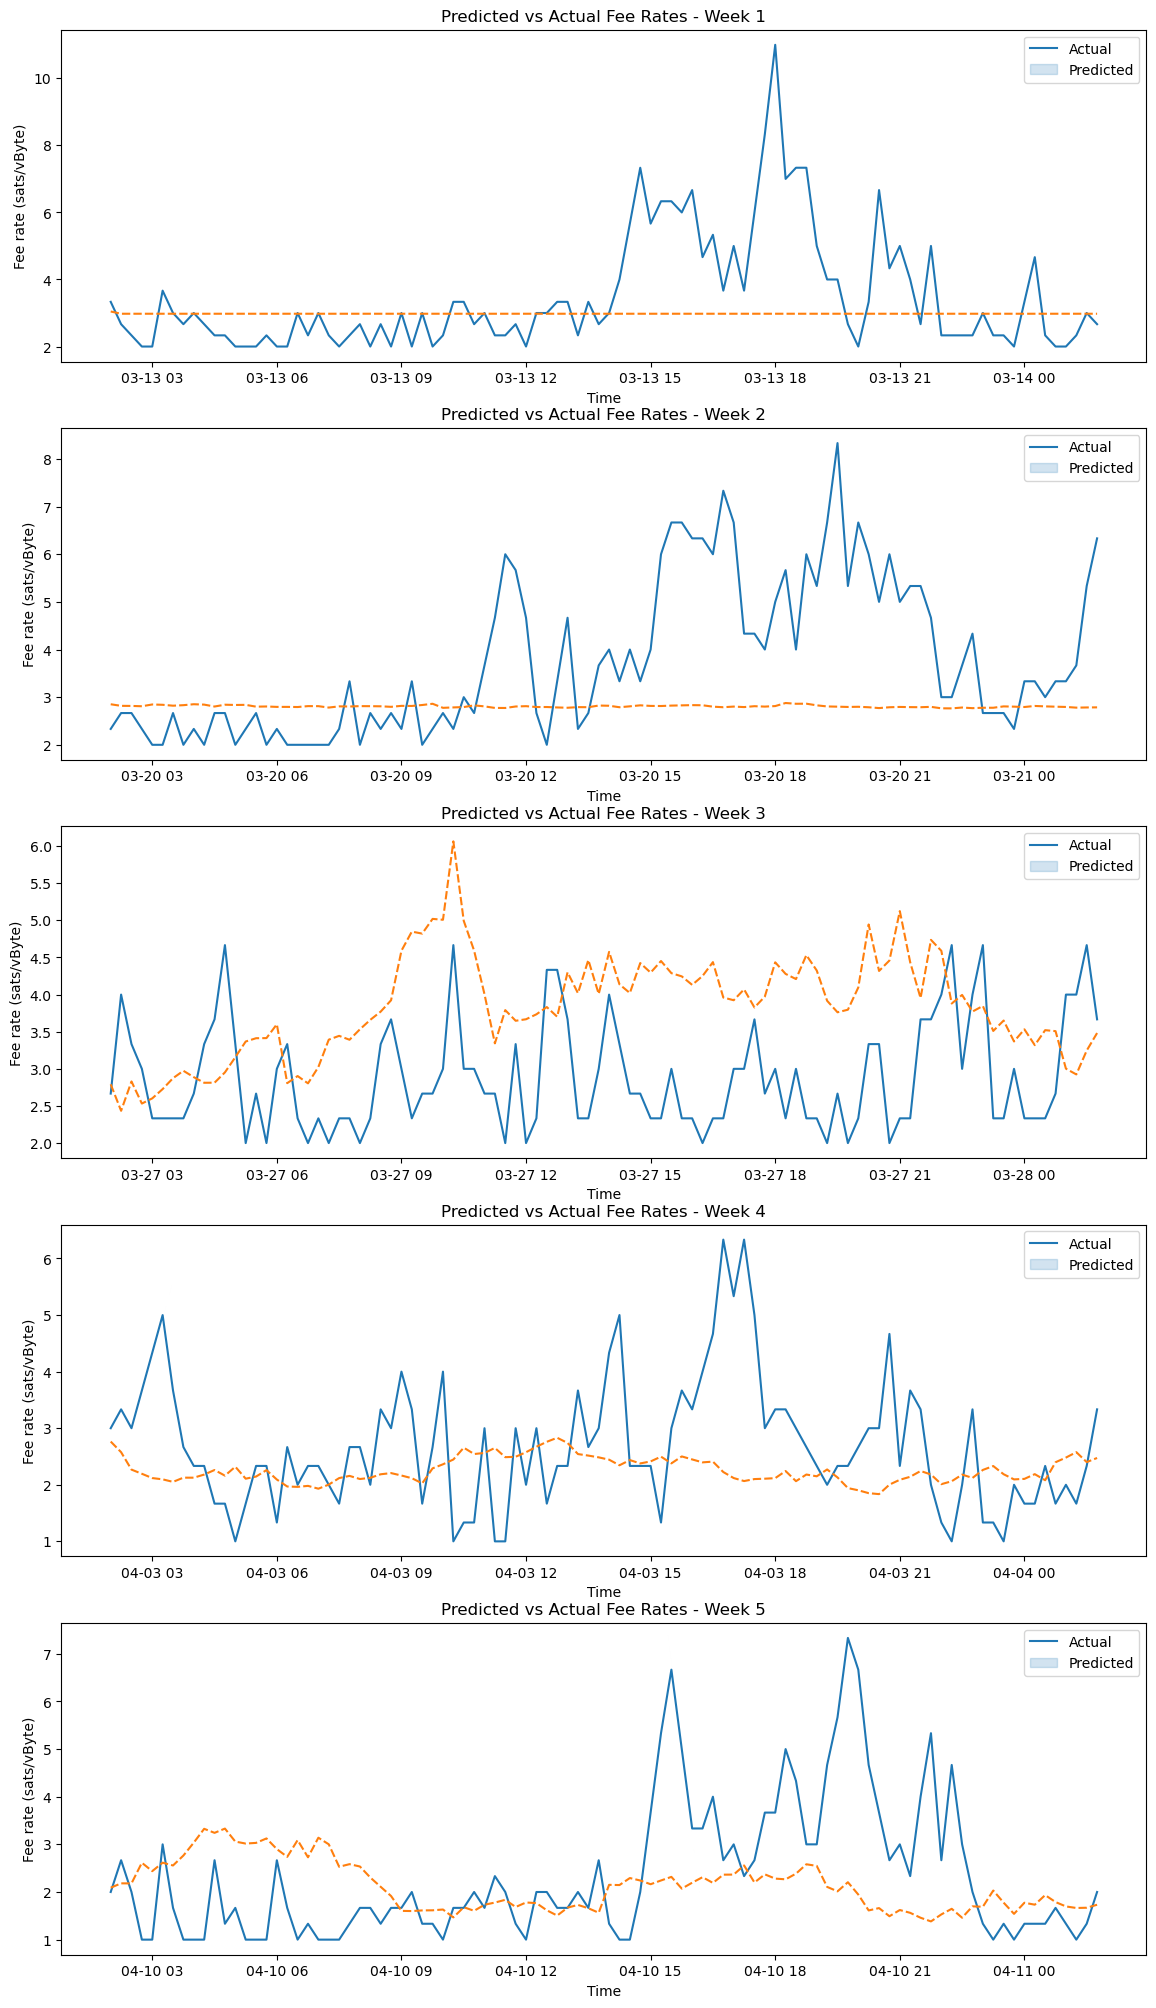

In [6]:
# plot
fig_sliding, axes_sliding = plt.subplots(nrows=5, ncols=1,figsize=(14, 25))

axes_sliding = axes_sliding.flatten()
for i in range(5):

    df_sliding = df[0+i*7*96:7*96+i*7*96]
    X_train, X_test, y_train, y_test = data_split(df_sliding,15)
    # plot
    result_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred_sliding[i]
    }, index=y_test.index)
    sns.lineplot(data=result_df, ax=axes_sliding[i])
    axes_sliding[i].set_title(f'Predicted vs Actual Fee Rates - Week {i+1}')
    axes_sliding[i].set_xlabel('Time')
    axes_sliding[i].set_ylabel('Fee rate (sats/vByte)')
    axes_sliding[i].legend(['Actual', 'Predicted'])


## Expanding window

The dataset contains 5-week data. Use the model to fit data from first 1 week to all 5 weeks.

In [7]:
y_pred_expanding = {}
# fh 
fh = ForecastingHorizon(np.arange(1, 97), is_relative=True)

avg_mae = 0
avg_rmse = 0
avg_mape = 0

base_avg_mae = 0
base_avg_rmse = 0
base_avg_mape = 0

for i in range(5):
    print((i+1),"Weeks")
    df_expanding = df[:7*96+i*7*96]
    X_train, X_test, y_train, y_test = data_split(df_expanding,15)
    random_search = build_random_search(y_train, param_dist,15,0)
    random_search.fit(X=X_train, y=y_train,fh=fh)
    best_forecaster = random_search.best_forecaster_
    print("Best parameters (MAE):", random_search.best_params_)
    
    y_pred_temp = best_forecaster.predict(fh=fh,X=X_test)
    y_pred_temp.index =X_test.index
    y_pred_expanding[i] = y_pred_temp

    y_baseline = [y_train.median()] * len(y_test)
    
    mae = mean_absolute_error(y_test, y_pred_temp)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_temp))
    mape = mean_absolute_percentage_error(y_test, y_pred_temp)

    base_mae = mean_absolute_error(y_test, y_baseline)
    base_rmse = np.sqrt(mean_squared_error(y_test, y_baseline))
    base_mape = mean_absolute_percentage_error(y_test, y_baseline)   
    
    avg_mae += mae
    avg_rmse += rmse
    avg_mape += mape
    
    base_avg_mae += base_mae
    base_avg_rmse += base_rmse
    base_avg_mape += base_mape

    
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}")

    print(f"Baseline MAE: {base_mae:.4f}")
    print(f"Baseline RMSE: {base_rmse:.4f}")
    print(f"Baseline MAPE: {base_mape:.4f}")

avg_mae /= 5
avg_rmse /= 5
avg_mape /= 5

base_avg_mae /= 5
base_avg_rmse /= 5
base_avg_mape /= 5

print("\n")
print("Average values: ")
print(f"MAE: {avg_mae:.4f}")
print(f"RMSE: {avg_rmse:.4f}")
print(f"MAPE: {avg_mape:.4f}")
print(f"Baseline MAE: {base_avg_mae:.4f}")
print(f"Baseline RMSE: {base_avg_rmse:.4f}")
print(f"Baseline MAPE: {base_avg_mape:.4f}")

1 Weeks
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Best parameters (MAE): {'estimator__subsample': 0.6, 'estimator__reg_lambda': 5, 'estimator__reg_alpha': 5, 'estimator__n_estimators': 50, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.01, 'estimator__gamma': 5, 'estimator__colsample_bytree': 0.8}
MAE: 1.1624
RMSE: 1.7819
MAPE: 0.2922
Baseline MAE: 1.1806
Baseline RMSE: 1.9070
Baseline MAPE: 0.2663
2 Weeks
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Best parameters (MAE): {'estimator__subsample': 0.6, 'estimator__reg_lambda': 10, 'estimator__reg_alpha': 5, 'estimator__n_estimators': 100, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.1, 'estimator__gamma': 5, 'estimator__colsample_bytree': 0.6}
MAE: 1.1797
RMSE: 1.6462
MAPE: 0.2647
Baseline MAE: 1.3750
Baseline RMSE: 1.9365
Baseline MAPE: 0.2979
3 Weeks
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Best parameters (MAE): {'estimator__subsample': 0.6, 'estimator__reg

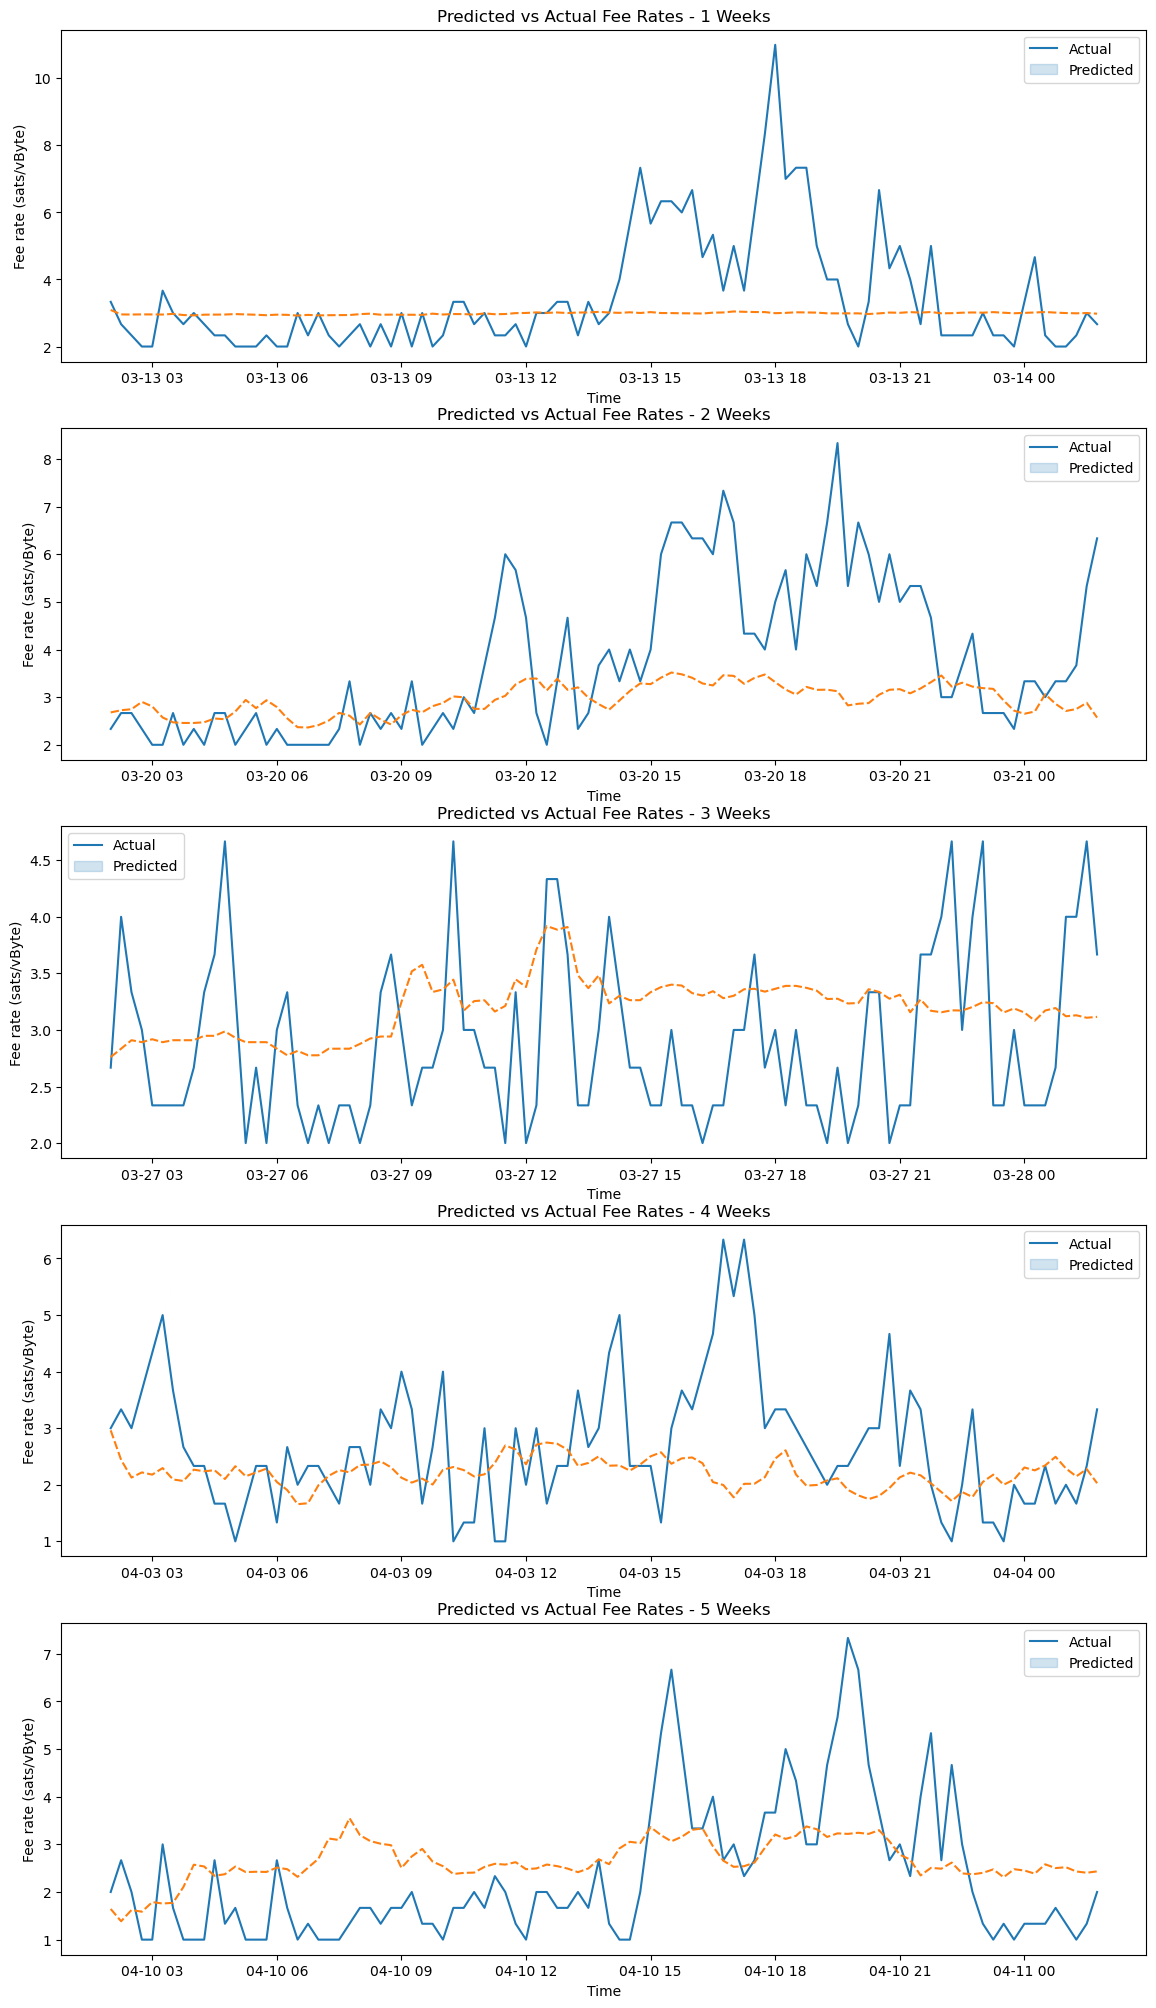

In [8]:
# plot
fig_expanding, axes_expanding = plt.subplots(nrows=5, ncols=1,figsize=(14, 25))

axes_expanding = axes_expanding.flatten()
for i in range(5):
    df_expanding = df[:7*96+i*7*96]
    X_train, X_test, y_train, y_test = data_split(df_expanding,15)
    
    result_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred_expanding[i]
    }, index=y_test.index)
    sns.lineplot(data=result_df, ax=axes_expanding[i])
    axes_expanding[i].set_title(f'Predicted vs Actual Fee Rates - {i+1} Weeks')
    axes_expanding[i].set_xlabel('Time')
    axes_expanding[i].set_ylabel('Fee rate (sats/vByte)')
    axes_expanding[i].legend(['Actual', 'Predicted'])